In [38]:
import numpy as np # для матричных вычислений
import pandas as pd # для анализа и предобработки данных
import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # для визуализации

%matplotlib inline
plt.style.use('seaborn')

In [39]:
from sklearn import preprocessing

К нам пришёл заказчик, которому необходимо проанализировать клиентов торгового центра и выделить разные группы покупателей, 

чтобы понять, как дальше развивать услуги торгового центра, магазины каких сегментов открывать.

В файле содержится основная информация о покупателе: идентификатор, возраст, пол, доход, индекс расходов. 

Индекс расходов считается на основе таких параметров, как поведение клиента и данные о покупках, и принимает значение от 1 до 100.

In [40]:
df = pd.read_csv('data/segmented_customers.zip')

In [41]:
df.head()

,customer_id,gender,age,annual_income,spending_score
0,1,1,19.0,15.0,39.0
1,2,1,21.0,15.0,81.0
2,3,0,20.0,16.0,6.0
3,4,0,23.0,16.0,77.0
4,5,0,31.0,17.0,40.0


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   customer_id     200 non-null    int64  
 1   gender          200 non-null    int64  
 2   age             200 non-null    float64
 3   annual_income   200 non-null    float64
 4   spending_score  200 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 7.9 KB


In [43]:
# посмотрим, есть ли пропуски в датасете
df.isna().sum()

customer_id       0
gender            0
age               0
annual_income     0
spending_score    0
dtype: int64

In [44]:
# переименуем столбцы для более удобной работы
df.rename(columns = {'CustomerID': 'customer_id', 'Gender': 'gender', 
                    'Age': 'age', 'Annual Income (k$)': 'annual_income', 
                    'Spending Score (1-100)': 'spending_score', }, inplace = True)

In [45]:
# проверим, есть ли в данных дубликаты
df[df.duplicated(subset='customer_id')]

,customer_id,gender,age,annual_income,spending_score


Чтобы мы могли визуально оценивать результаты кластеризации, будем проводить её по трём признакам, а именно: 
- годовой заработок
- коэффициент покупательской способности
- возраст

Визуализируем распределение данных:

In [46]:
import plotly
import plotly.express as px

# передаём датафрейм и поля, которые нужно использовать для осей абсцисс, ординат и аппликат
fig = px.scatter_3d(
    data_frame=df, 
    x = 'age', 
    y = 'annual_income', 
    z = 'spending_score', 
    width=1500,
    height=900
)

#отображаем график
fig.show()

Так как нам часто будет требоваться визуализировать результаты кластеризации, напишем для этого функцию. 

Она будет принимать датафрейм и название столбца датафрейма с результатами кластеризации. 

Так как нас будут стабильно интересовать три столбца (age, annual_income, spending_score), зафиксируем их названия внутри функции:

In [47]:
def get_3d_visualization(df, clust_res):
    fig = px.scatter_3d(
        data_frame=df, 
        x = 'age', 
        y = 'annual_income', 
        z = 'spending_score', 
        color = clust_res,
        width=1000,
        height=700
    )

    #возвращаем график
    return fig

In [48]:
X = df[['age', 'annual_income', 'spending_score']]

### Задание 10.1
Попробуйте провести DBSCAN-кластеризацию со значениями по умолчанию. Сколько кластеров у вас получилось?

In [49]:
# импортируем DBSCAN кластеризацию
from sklearn.cluster import DBSCAN

# запускаем кластеризацию на наших данных
dbscan_clustering = DBSCAN()
dbscan_clustering.fit(X)

df['dbscan_res'] = dbscan_clustering.labels_

In [50]:
df['dbscan_res'].value_counts()

-1    200
Name: dbscan_res, dtype: int64

In [51]:
get_3d_visualization(df, 'dbscan_res')

Алгоритм посчитал всё выбросами

Как видно, алгоритм плохо работает с настройками по умолчанию, поэтому попробуем изменить их.

Большая часть наших данных разрежённые, а чем больше разброс точек в датасете, 
тем большее значение радиуса вокруг точки (eps) нужно задавать. 
Так как данные разрежённые, попробуем увеличить значение eps до 11 и визуально оценим результат:

In [52]:
# запускаем кластеризацию на наших данных
dbscan = DBSCAN(eps=1, min_samples=3)

clustering_dbscan_res = dbscan.fit_predict(X)
df['dbscan_res_eps_11'] = clustering_dbscan_res

get_3d_visualization(df, 'dbscan_res_eps_11')

In [53]:
eps_range = np.arange(1, 20, 0.5)
min_samples_range = np.arange(3, 13)
min_samples_range

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [54]:
eps_range = np.arange(9, 13, 1)
min_samples_range = np.arange(4, 7)

In [55]:
col_list = []

for min_samples in min_samples_range:
    for eps in eps_range:
        col_name = f'eps_{eps}_min_samples_{min_samples}'
        
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)      
        df[col_name] = dbscan.fit_predict(X)
        col_list.append(col_name)

In [56]:
len(col_list)

12

In [57]:
# for col in col_list:
#     get_3d_visualization(df, col).show()

Проведём агломеративную кластеризацию, чтобы построить дендрограмму и по ней оценить количество кластеров, 

на которое можно разделить датасет. 

Напишем функцию, которая будет принимать количество кластеров и матрицу с признаками:

In [58]:
# импортируем алгомеративную кластеризацию из sklearn
from sklearn.cluster import AgglomerativeClustering

# напишем функцию, которая будет проводить алгомеративную кластеризацию
# на вход она будет принимать X — матрицу с признаками для кластеризации и n_clusters — количество кластеров,
# на выходе будет возвращать список с номерами кластеров
def get_aggl_clustering(X, n_clusters):
    # запустим агломеративную кластеризацию
    agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    # обучим модель агломеративной кластеризации
    agglomerative_clustering.fit(X)
    # получим список c информацией, к какому кластеру относятся объекты
    aggl_prediction = agglomerative_clustering.labels_
    # вернём список с результатами
    return aggl_prediction

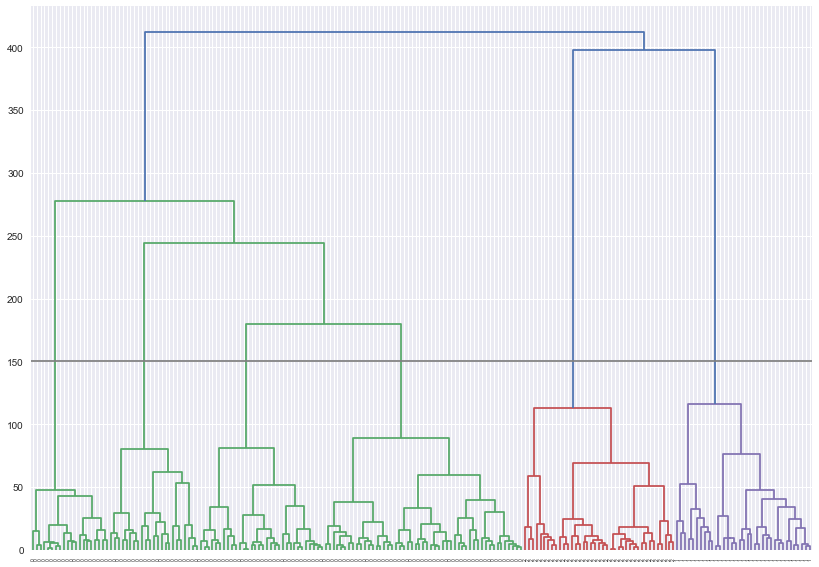

In [59]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(X, 'ward')


plt.figure(figsize=(14, 10))

dendrogram(linked,
            orientation='top',
            labels=get_aggl_clustering(X, 3),
            distance_sort='descending',
            show_leaf_counts=True)

plt.axhline(y=150, color='gray')

plt.show()

Как мы можем судить из дендрограммы, если взять евклидово расстояние между кластерами, равное 150, датасет будет делиться на шесть кластеров

Давайте визуально оценим, что из этого получилось. Для этого обучим модель агломеративной кластеризации с количеством кластеров, равным 6:

In [60]:
df['aggl_res_6'] = get_aggl_clustering(X, 6)
get_3d_visualization(df, 'aggl_res_6')

Теперь давайте воспользуемся коэффициентом силуэта и узнаем оптимальное количество кластеров. 

Совпадает ли это число с тем, что мы подобрали, используя дендрограмму?

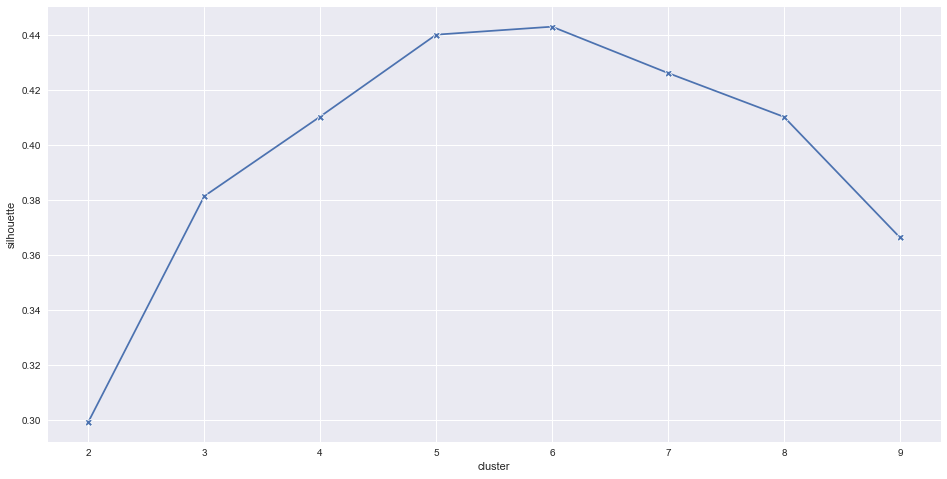

In [61]:
# импортируем метрику силуэт
from sklearn.metrics import silhouette_score

# напишем функцию, как и при подсчете метода локтя
def get_silhouette(cluster_num, X):
    aggl_prediction = get_aggl_clustering(X, cluster_num)
    
    # подсчитаем метрику силуэта, передав данные и то, к каким кластерам относятся объекты
    silhouette = silhouette_score(X, aggl_prediction)
    
    return silhouette


# создадим пустой словарь, ключами будут инерция и количество кластеров
silhouette_res = {'silhouette': [], 'cluster': []}


for cluster_num in range(2, 10):
    silhouette_res['silhouette'].append(get_silhouette(cluster_num, X))
    silhouette_res['cluster'].append(cluster_num)
    
# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# установим стиль для визуализиции
sns.set_style('darkgrid')

# визуализируем зависимость значения инерции от количества кластеров
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(data=silhouette_df, x='cluster', y='silhouette', marker= 'X', ax=ax)
plt.show()

Теперь рассмотрим столбец cluster: 

в нём есть информация о том, к какому кластеру должен принадлежать каждый объект из датасета. 

Значит, мы можем проверить качество кластеризации, посчитав различные метрики.

In [62]:
cluster_df = pd.read_csv('data/segmented_customers_cluster.zip')

In [64]:
y = cluster_df['cluster']

In [ ]:
y_pred = df['aggl_res_6']

Нам очень важно, чтобы в ходе кластеризации не были выделены лишние группы, так как это помешает анализу покупателей. 

Таким образом, нужно, чтобы кластеры получались максимально наполненными элементами.

Какую метрику вы будете использовать?

In [66]:
# импортируем подсчёт метрики однородности кластеров
from sklearn.metrics.cluster import completeness_score
# передаём предсказанную информацию (к какому кластеру относятся объекты датасета) и правильные ответы
print(completeness_score(labels_true=y, labels_pred=y_pred))


0.9858363091910892
